In [1]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import torch
import matplotlib.pyplot as plt

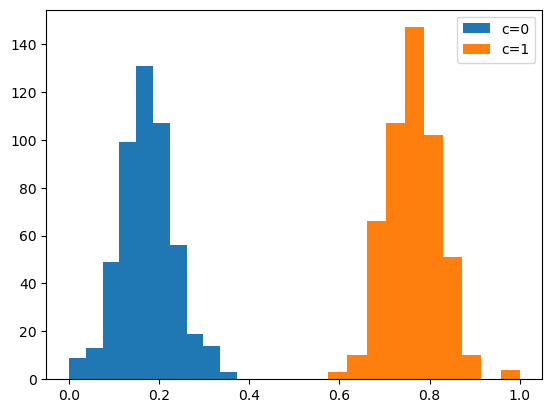

In [13]:
# data
# set seed for reproducibility
torch.manual_seed(0)
N = 1000
c = torch.cat([torch.ones((N//2,1)), torch.zeros((N//2,1))], dim=0)
X = torch.randn((N,1)) * 0.1 + c
X = (X - X.min()) / (X.max() - X.min())
# hist X, color by c
plt.hist(X[c == 0].ravel(), label = 'c=0')
plt.hist(X[c == 1].ravel(), label = 'c=1')
plt.legend();
# save torch tensor X and c 
torch.save(X, '/hpc/home/zw122/tree_condsamp/LACE/tree-toy/pretrained/X.pt')
torch.save(c, '/hpc/home/zw122/tree_condsamp/LACE/tree-toy/pretrained/c.pt')


In [17]:
# train tree boosting
bpm = importr('boostPM')
import rpy2.robjects as robj
def torch2rmat(tensor):
    nr, nc = tensor.shape
    xvec = robj.FloatVector(tensor.numpy().transpose().reshape((tensor.numel())))
    xr = robj.r.matrix(xvec, nrow=nr, ncol=nc)
    return xr
data = torch2rmat(X)
out = bpm.boosting(data)
# save out
robj.r.saveRDS(out, file='/hpc/home/zw122/tree_condsamp/LACE/tree-toy/pretrained/out.rds')

Estimating the marginal distribution... (1/1)
100 trees are constructed in this step
Estimating the dependency structure...
1000 trees are constructed in this step
Time difference of 0.1389797 secs


<rpy2.rinterface_lib.sexp.NULLType object at 0x7f025435a580> [RTYPES.NILSXP]

In [57]:
# define generator
out1 = robj.r.readRDS('/hpc/home/zw122/tree_condsamp/LACE/tree-toy/pretrained/out.rds')
m = torch.distributions.normal.Normal(0, 1)
def g(z, out): #z:nsample * d
    # apply gaussian CDF to z
    u = torch2rmat(torch.transpose(m.cdf(z.reshape(-1,1)),0,1))
    # gz = fast_func.MC_reverse(u, x, trees, c0, gamma, ydim) 
    gz = bpm.simulation_b(out,z.shape[0],u)
    # turn gz into a tensor
    gz = torch.tensor(gz)
    gz.requires_grad = True
    return gz

In [60]:
z = m.sample((1000,1))
gz = g(z, out1)